In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import shap
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
%matplotlib inline

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
df_train_path = os.path.join('data','df_train_scaled.csv')
df_test_path = os.path.join('data','df_test_scaled.csv')

#download in chunks
df_train = pd.read_csv(df_train_path, index_col=0, compression='zip')
df_test = pd.read_csv(df_test_path, index_col=0, compression='zip')

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [3]:
df_train.shape,df_test.shape

((1038769, 21), (194208, 21))

In [4]:
target_col = 'loan_status'

#feature space
X_train = df_train.drop(columns=[target_col])
X_test = df_test.drop(columns=[target_col])

#target variable
y_train = df_train[target_col]
y_test = df_test[target_col]


In [5]:
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfpvalue= pd.DataFrame(fit.pvalues_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfpvalue,dfscores],axis=1)
featureScores.columns = ['Specs','pvalue','Score']  #naming the dataframe columns
print(featureScores.nlargest(21,'Score'))  #print 10 best features

                   Specs         pvalue         Score
3              sub_grade   0.000000e+00  82716.596427
2                  grade   0.000000e+00  78921.079651
1               int_rate   0.000000e+00  77244.324032
0                   term   0.000000e+00  43273.289224
17    balance_annual_inc   0.000000e+00  20061.284425
18        fico_avg_score   0.000000e+00  18224.824517
9                    dti   0.000000e+00  12992.222770
19       inst_amnt_ratio   0.000000e+00   6484.992967
7    verification_status   0.000000e+00   4504.016610
13              mort_acc   0.000000e+00   4031.952355
12            revol_util   0.000000e+00   3181.475302
6             annual_inc   0.000000e+00   3162.532152
16     credit_line_ratio   0.000000e+00   3040.866342
5         home_ownership   0.000000e+00   2317.222821
15           credit_hist   0.000000e+00   1580.023596
10               pub_rec  4.117764e-251   1146.202575
14  pub_rec_bankruptcies  1.498258e-163    743.035462
11             revol_bal   7

In [6]:
drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']

In [7]:
X_train=X_train.drop(columns=drop_columns)
X_test =X_test.drop(columns=drop_columns)

In [8]:
X_train.shape,X_test.shape

((1038769, 13), (194208, 13))

In [9]:
#ROC dict for TPR and FPR values
roc_dict = {}

#precision recall curve
prc_dict = {}


def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

In [10]:
def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
    """
    fits a classifer from sklearn and returns a dataframe
    clf(sklearn): classifier
    X_train(numpy): train features
    y_train(numpy): predictions row vector
    X_test(numpy): test features
    y_test(numpy): ground truth row vector
    name(string): name of classifier
    
    """
    #fit to train data
    clf.fit(X_train, y_train)
    #make predictions
    y_pred = clf.predict(X_test)
    #make dataframe from report
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    #add clf name as column
    clf_report['clf'] = name
    
    return clf_report

In [11]:
#instantiate with default params
lr  = LogisticRegression(penalty='l2',
                         C=1.0,
                         solver = 'lbfgs',
                         max_iter=400,
                         n_jobs=-1)

lr_report = fit_score_clf(lr, X_train, y_train, X_test, y_test, name='lr')
lr_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.732138,0.582242,0.72807,0.657190,0.690708,lr
recall,0.984331,0.057174,0.72807,0.520753,0.728070,lr
f1-score,0.839708,0.104124,0.72807,0.471916,0.636397,lr
support,140530.000000,53678.000000,0.72807,194208.000000,194208.000000,lr


In [12]:
#metrics for lr
modify_roc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression', 
                dict_modify=roc_dict)
modify_prc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression',
                dict_modify=prc_dict)

In [13]:
gbtree = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.732263,0.602549,0.728909,0.667406,0.696411,gbtree
recall,0.985797,0.056373,0.728909,0.521085,0.728909,gbtree
f1-score,0.840323,0.103101,0.728909,0.471712,0.636559,gbtree
support,140530.000000,53678.000000,0.728909,194208.000000,194208.000000,gbtree


In [14]:
#metrics for gbtree
modify_roc_dict(gbtree, y_test, X_test, name='GBTree',dict_modify=roc_dict)

In [15]:
modify_prc_dict(clf=gbtree,
                y_test=y_test,
                X_test=X_test,
                name='GBTree',
                dict_modify=prc_dict)

In [16]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rf_report = fit_score_clf(rf, X_train, y_train, X_test, y_test, name='rf')
rf_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.737028,0.573813,0.72998,0.655421,0.691916,rf
recall,0.974568,0.089646,0.72998,0.532107,0.729980,rf
f1-score,0.839315,0.155066,0.72998,0.497190,0.650192,rf
support,140530.000000,53678.000000,0.72998,194208.000000,194208.000000,rf


In [17]:
#metrics for random forest
modify_roc_dict(rf, y_test, X_test, name='RandomForest',dict_modify=roc_dict)

In [18]:
modify_prc_dict(clf=rf,
                y_test=y_test,
                X_test=X_test,
                name='RandomForest',
                dict_modify=prc_dict)

In [19]:
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                     subsample=0.9,
                            n_jobs=-1)
xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')
xgb_report.head()


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.739694,0.556853,0.729774,0.648273,0.689157,xgb
recall,0.966776,0.109300,0.729774,0.538038,0.729774,xgb
f1-score,0.838126,0.182733,0.729774,0.510429,0.656979,xgb
support,140530.000000,53678.000000,0.729774,194208.000000,194208.000000,xgb


In [20]:
#metrics for xgb
modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)

In [21]:
modify_prc_dict(clf=xgb_clf,
                y_test=y_test,
                X_test=X_test,
                name='XGBoost',
                dict_modify=prc_dict)

In [22]:
#put hard limit on iterations to save time in exploration phase
svc = SVC(C=1.0, kernel='rbf',
          gamma='auto', 
          probability=True,
          max_iter=400)

svc_report = fit_score_clf(svc, X_train, y_train, X_test, y_test, name='svc')
svc_report.head()

Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.726260,0.289456,0.652496,0.507858,0.605529,svc
recall,0.834178,0.176851,0.652496,0.505514,0.652496,svc
f1-score,0.776487,0.219557,0.652496,0.498022,0.622555,svc
support,140530.000000,53678.000000,0.652496,194208.000000,194208.000000,svc


In [23]:
#metrics for svc
modify_roc_dict(svc, y_test, X_test, name='SVC',dict_modify=roc_dict)

In [24]:
modify_prc_dict(clf=svc,
                y_test=y_test,
                X_test=X_test,
                name='SVC',
                dict_modify=prc_dict)

In [25]:
knn = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_report = fit_score_clf(knn, X_train, y_train, X_test, y_test, name='KNN')
knn_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.742594,0.446715,0.712916,0.594654,0.660815,KNN
recall,0.923305,0.162115,0.712916,0.542710,0.712916,KNN
f1-score,0.823148,0.237896,0.712916,0.530522,0.661388,KNN
support,140530.000000,53678.000000,0.712916,194208.000000,194208.000000,KNN


In [26]:
#metrics for knn
modify_roc_dict(knn, y_test, X_test, name='KNN',dict_modify=roc_dict)

In [27]:
modify_prc_dict(clf=knn,
                y_test=y_test,
                X_test=X_test,
                name='knn',
                dict_modify=prc_dict)

In [28]:
#see keys we have
roc_dict.keys()

dict_keys(['Logistic Regression', 'GBTree', 'RandomForest', 'XGBoost', 'SVC', 'KNN'])

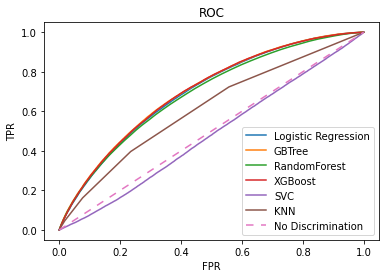

In [29]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.savefig(os.path.join('roc_curve_all_models.png'))
plt.legend()
plt.show()

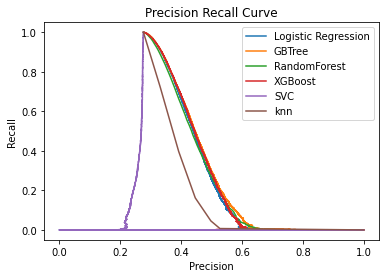

In [30]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.legend()

plt.savefig(os.path.join('prc_curve_all_models.png'))


plt.show()

In [31]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1,
                           scale_pos_weight=estimate)

xgb_clf.fit(X_train, y_train)

Estimate: 4.020


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=4.019856764541009, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
#define location to save trained model
save_model_dir = os.path.join('models/xgb_default_params.pickle')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(xgb_clf,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: models/xgb_default_params.pickle


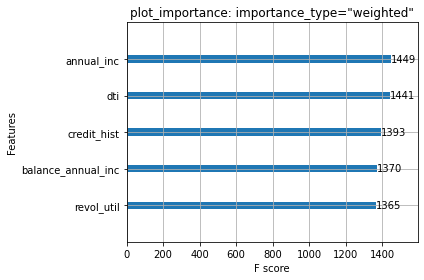

In [33]:

#”weight” is the number of times a feature appears in a tree
xgb.plot_importance(xgb_clf, 
                    importance_type='weight',
                    max_num_features=5, 
                    title='plot_importance: importance_type="weighted"')
plt.tight_layout()
plt.show()

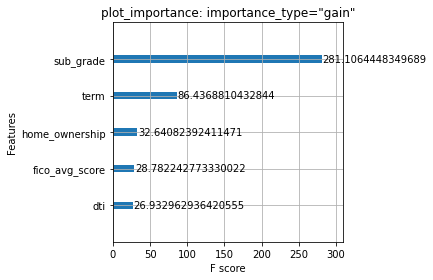

In [34]:
#”gain” is the average gain of splits which use the feature

xgb.plot_importance(xgb_clf, 
                    importance_type='gain',
                    max_num_features=5, 
                    title='plot_importance: importance_type="gain"')
plt.tight_layout()
plt.show()

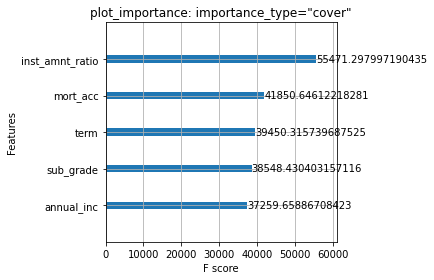

In [35]:
#is the average coverage of splits which use the feature 
#where coverage is defined as the number of samples affected by the split

xgb.plot_importance(xgb_clf, 
                    importance_type='cover',
                    max_num_features=5, 
                    title='plot_importance: importance_type="cover"')
plt.tight_layout()
plt.show()

In [36]:
y_pred=xgb_clf.predict(X_test)
y_prob=xgb_clf.predict_proba(X_test)

In [37]:
y_prob=y_prob[:, 1] #keeping only positive outcomes

In [38]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred))

[[91648 48882]
 [19700 33978]]
              precision    recall  f1-score   support

           0       0.82      0.65      0.73    140530
           1       0.41      0.63      0.50     53678

    accuracy                           0.65    194208
   macro avg       0.62      0.64      0.61    194208
weighted avg       0.71      0.65      0.66    194208



In [39]:
...
# calculate AUC
auc = roc_auc_score(y_test, y_prob)
print('AUC: %.3f' % auc)

AUC: 0.697
